# QRT ENS Challenge Data 2023 - Benchmark

Ce notebook détaille la construction du benchmark de ce challenge - il peut également être utile aux participants pour se lancer dans la compétition. 

## Librairies

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

# Chargement des données

- `X_train` et `X_test` ont  $10$ colonnes qui représentent les même variables explicatives mais sur des périodes de temps différentes il y a au plus $10 604$ lignes. 

- `X_train` et `y_train` partagent la même colonne `DELIVERY_START` - chaque ligne a un DELIVERY_START unique associéz à une date et heure de livraison de l'électricité
. 

- La variable cible `spot_id_delta` de `y_train` correspond à l'écart entre le VWAP des transactions sur le marché infra-journalier (Intraday) et le prix SPOT pour 1MWh d'électricité (spot_id_delta = Intraday - SPOT) : si la valeur est positive, le prix Intraday est supérieur au prix SPOT et inversement.

- **On notera que certaines colonnes ont des valeurs manquantes**.


In [2]:
# After downloading the X_train/X_test/Y_train .csv files in your working directory:
X = pd.read_csv('../data/X_train.csv')
y = pd.read_csv('../data/y_train.csv')
X_rendu = pd.read_csv('../data/X_test.csv')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train = X_train.dropna(subset=['coal_power_available', 'gas_power_available', 'nucelear_power_available', 'wind_power_forecasts_average', 'solar_power_forecasts_average', 'wind_power_forecasts_std', 'solar_power_forecasts_std'])
X_rendu = X_train.dropna(subset=['coal_power_available', 'gas_power_available', 'nucelear_power_available', 'wind_power_forecasts_average', 'solar_power_forecasts_average', 'wind_power_forecasts_std', 'solar_power_forecasts_std'])

In [3]:
X_train.head()

,DELIVERY_START,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
5984,2022-09-17 10:00:00+02:00,42593.0,2226.0,10819.0,27360.0,4079.0,6062.0,110.569548,36.878399,NaN
10118,2023-03-09 16:00:00+01:00,52698.0,3386.0,11945.0,39815.0,11812.0,2777.0,505.979474,103.648685,118.64
8138,2022-12-16 04:00:00+01:00,60213.0,3386.0,11742.0,41880.0,5734.0,0.0,132.079212,0.000000,NaN
4849,2022-07-29 03:00:00+02:00,NaN,2226.0,11525.0,26430.0,1633.0,0.0,30.453919,0.000000,NaN
3353,2022-05-24 19:00:00+02:00,47934.0,2806.0,11140.0,30099.0,2284.0,1473.0,161.078062,25.593526,NaN


In [4]:
X_train.describe()

,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
count,6490.000000,7396.000000,7396.000000,7396.000000,7396.000000,7396.000000,7396.000000,7396.000000,1267.000000
mean,53824.212481,2821.648459,11459.129935,35387.822742,4503.145484,1937.115197,125.619925,25.246948,140.322739
std,11369.806405,493.577963,484.880880,7663.645923,3324.943411,2720.520151,130.758405,43.575693,33.981070
min,30515.000000,1646.000000,9790.000000,22285.000000,592.000000,0.000000,1.830211,0.000000,42.420000
25%,45464.250000,2226.000000,11140.000000,28989.000000,2045.750000,0.000000,46.555642,0.000000,120.035000
50%,51882.500000,2806.000000,11487.000000,32463.000000,3315.500000,157.000000,86.270471,3.640927,139.720000
75%,62242.000000,3386.000000,11945.000000,43180.000000,5932.500000,3552.000000,156.118847,35.254117,160.540000
max,85145.000000,3386.000000,11963.000000,50122.000000,15167.000000,10127.000000,1667.688143,745.261316,254.190000


In [5]:
y_train.head()

,DELIVERY_START,spot_id_delta
5984,2022-09-17 10:00:00+02:00,-37.905677
10118,2023-03-09 16:00:00+01:00,24.399947
8138,2022-12-16 04:00:00+01:00,-17.531674
4849,2022-07-29 03:00:00+02:00,-10.448003
3353,2022-05-24 19:00:00+02:00,18.265919


In [6]:
y_train.describe()

,spot_id_delta
count,7423.000000
mean,0.736097
std,40.075981
min,-1567.353547
25%,-12.038325
50%,0.042506
75%,12.210459
max,658.961329


In [7]:
X_test.head()

,DELIVERY_START,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
1792,2022-03-18 09:00:00+01:00,62432.0,2806.0,11952.0,36810.0,7078.0,2693.0,93.089615,55.392716,NaN
6734,2022-10-18 16:00:00+02:00,46182.0,2806.0,11480.0,29250.0,2018.0,4697.0,24.670262,75.358714,NaN
3667,2022-06-07 21:00:00+02:00,44381.0,2226.0,10840.0,30098.0,2428.0,146.0,119.820776,5.263318,NaN
7756,2022-11-30 06:00:00+01:00,58595.0,3386.0,11945.0,34706.0,1625.0,0.0,29.010760,0.000000,NaN
3068,2022-05-12 22:00:00+02:00,46170.0,2806.0,11140.0,29640.0,2046.0,0.0,50.109943,0.000000,NaN


<AxesSubplot:>

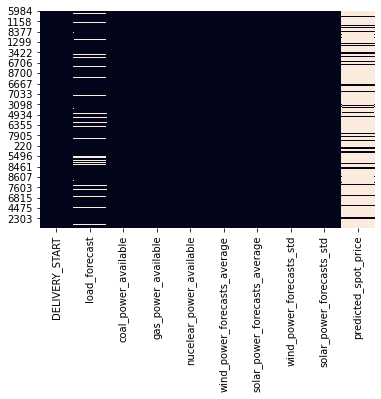

In [8]:
sns.heatmap(X_rendu.isna(),cbar=False)

# Data analysis

Représentation graphique des données de test de notre modèle :

## 1) Histogramme des données d'apprentissage

array([[<AxesSubplot:title={'center':'load_forecast'}>,
        <AxesSubplot:title={'center':'coal_power_available'}>,
        <AxesSubplot:title={'center':'gas_power_available'}>],
       [<AxesSubplot:title={'center':'nucelear_power_available'}>,
        <AxesSubplot:title={'center':'wind_power_forecasts_average'}>,
        <AxesSubplot:title={'center':'solar_power_forecasts_average'}>],
       [<AxesSubplot:title={'center':'wind_power_forecasts_std'}>,
        <AxesSubplot:title={'center':'solar_power_forecasts_std'}>,
        <AxesSubplot:title={'center':'predicted_spot_price'}>]],
      dtype=object)

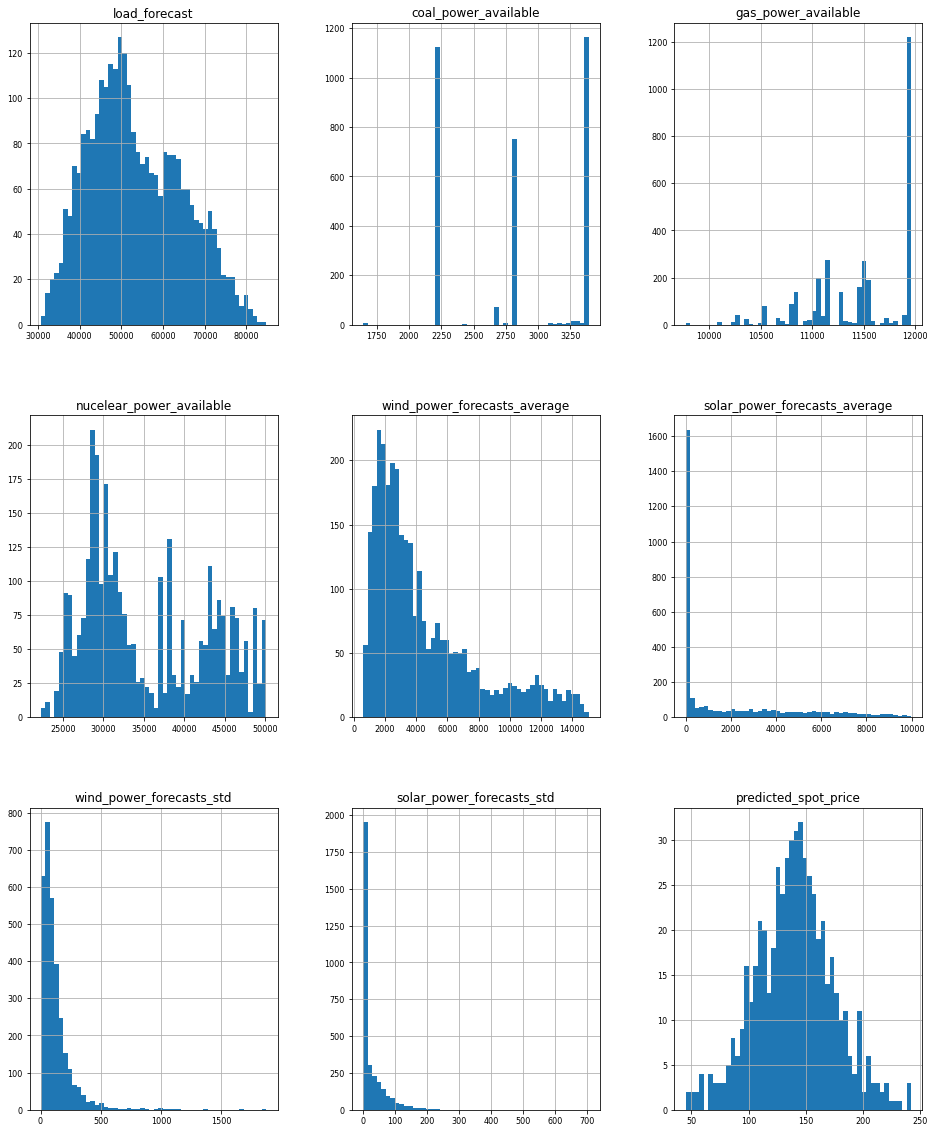

In [9]:
X_test.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

## 2) Répartition des *spot_id_delta* dans *y_train*

C:\Users\matte\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='spot_id_delta', ylabel='Density'>

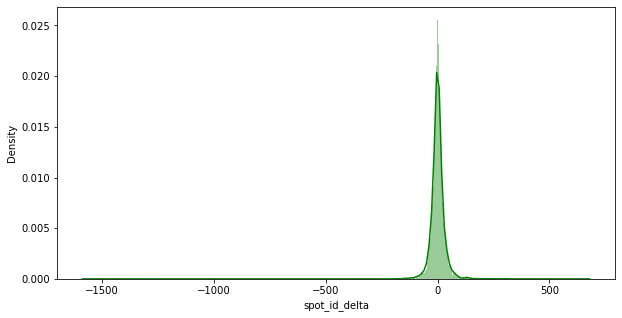

In [10]:
plt.figure(figsize=(10, 5))
sns.distplot(y_train['spot_id_delta'], color='g', bins=1000, hist_kws={'alpha': 0.4})

## 3) Corrélation générale entre les paramètres du modèle :

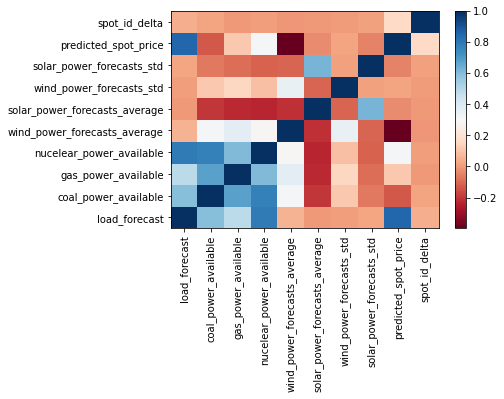

In [11]:
df = pd.merge(X_train, y_train, on='DELIVERY_START', how='inner')
tab=df.corr()
fig, ax = plt.subplots()
im = ax.pcolor(tab, cmap='RdBu')
row_labels = tab.columns
col_labels = tab.index
ax.set_xticks(np.arange(tab.shape[1])+0.5, minor= False)
ax.set_yticks(np.arange(tab.shape[0])+0.5, minor= False)
ax.set_xticklabels(row_labels, minor = False)
ax.set_yticklabels(col_labels, minor = False)
plt.xticks(rotation=90)
fig.colorbar(im)
plt.show()

# Data cleaning

On s'intéresse ici à la présence de nombreuses valeurs NaN. Ces valeurs représentent un vrai manque pour l'entraînement de notre modèle car elles sont majoritairement situées sur les données très corrélées avec le *spot_id_delta*.

## 1) Valeurs aberrantes dans *y_train*

Comme vu lors de la partie Data Analysis, certaines des valeurs de *y_train* (3) ont des valeurs très éloignées des autres. On s'occupe donc ici de retirer ces valeurs qui ne semblent pas cohérentes pour notre modèle :

In [12]:
y_train.head()

,DELIVERY_START,spot_id_delta
5984,2022-09-17 10:00:00+02:00,-37.905677
10118,2023-03-09 16:00:00+01:00,24.399947
8138,2022-12-16 04:00:00+01:00,-17.531674
4849,2022-07-29 03:00:00+02:00,-10.448003
3353,2022-05-24 19:00:00+02:00,18.265919


In [13]:
threshold = 600

eliminated_starts = y_train[abs(y_train['spot_id_delta']) - threshold >= 0].DELIVERY_START

y_train = y_train[~y_train['DELIVERY_START'].isin(eliminated_starts)] # on ne sélectionne que les valeurs qui ne correspondent pas aux dates enlevées
X_train = X_train[~X_train['DELIVERY_START'].isin(eliminated_starts)] # de même ici pour être cohérent sur le nombre de lignes

y_train.to_csv('../data/y_train_clean.csv', index=False)
# X_train to_csv à la fin

In [14]:
eliminated_starts.size

3

## 2) Prédiction de *load_forecast*

Il y a environ 1500 données manquantes, que l'on va prédire à l'aide d'un modèle de régression Ridge:

<AxesSubplot:>

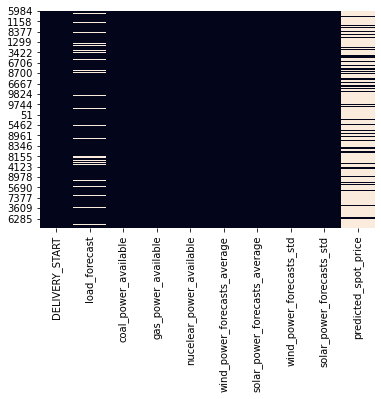

In [15]:
sns.heatmap(X_train.isna(),cbar=False)

In [16]:
predicted_spot_price_train = X_train['predicted_spot_price']
predicted_spot_price_rendu = X_rendu['predicted_spot_price']

In [17]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

y_load = X_train.dropna(subset=['load_forecast'])['load_forecast']
X_load = X_train.dropna(subset=['load_forecast'])
X_load = X_load.loc[:, X_load.columns != 'predicted_spot_price']
X_load = X_load.loc[:, X_load.columns != 'load_forecast']

X_train_load, X_test_load, y_train_load, y_test_load = train_test_split(X_load, y_load, test_size=0.3)

clf = LinearRegression()
clf.fit(X_train_load.set_index('DELIVERY_START'), y_train_load)
print('linear regression score: ', clf.score(X_test_load.set_index('DELIVERY_START'), y_test_load))

clf = GradientBoostingRegressor()
clf.fit(X_train_load.set_index('DELIVERY_START'), y_train_load)
print('gradient boosting regression score: ', clf.score(X_test_load.set_index('DELIVERY_START'), y_test_load))

clf = RandomForestRegressor()
clf.fit(X_train_load.set_index('DELIVERY_START'), y_train_load)
print('random forest regression score: ', clf.score(X_test_load.set_index('DELIVERY_START'), y_test_load))

linear regression score:  0.6707459050358678
gradient boosting regression score:  0.7958027800267109
random forest regression score:  0.8809966571223234



On choisit donc ici la régression ayant le meilleur score : Random Forest. On peut maintenant prédire les valeurs manquantes pour le *load_forecast* :

In [18]:
X_predict_load = X_train[X_train['load_forecast'].isna()]
X_predict_load = X_predict_load.loc[:, X_predict_load.columns != 'predicted_spot_price']
X_predict_load = X_predict_load.loc[:, X_predict_load.columns != 'load_forecast']

X_predict_load_rendu = X_rendu[X_rendu['load_forecast'].isna()]
X_predict_load_rendu = X_predict_load_rendu.loc[:, X_predict_load_rendu.columns != 'predicted_spot_price']
X_predict_load_rendu = X_predict_load_rendu.loc[:, X_predict_load_rendu.columns != 'load_forecast']

X_predict_load.insert(1, 'load_forecast', clf.predict(X_predict_load.set_index('DELIVERY_START')))
X_predict_load = X_predict_load.join(X_train.pop('predicted_spot_price'))

X_predict_load_rendu.insert(1, 'load_forecast', clf.predict(X_predict_load_rendu.set_index('DELIVERY_START')))
X_predict_load_rendu = X_predict_load_rendu.join(X_rendu.pop('predicted_spot_price'))

X_predict_load.head()

,DELIVERY_START,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
4849,2022-07-29 03:00:00+02:00,38650.05,2226.0,11525.0,26430.0,1633.0,0.0,30.453919,0.000000,NaN
4223,2022-07-03 01:00:00+02:00,39368.68,2226.0,10555.0,28140.0,1655.0,0.0,23.064629,0.000000,NaN
4682,2022-07-22 04:00:00+02:00,39358.58,2226.0,11525.0,27380.0,2531.0,0.0,89.148587,0.000000,NaN
4320,2022-07-07 02:00:00+02:00,37014.35,2226.0,11115.0,27905.0,3116.0,0.0,65.772533,0.000000,NaN
4793,2022-07-26 19:00:00+02:00,46925.79,2226.0,11525.0,25582.0,2759.0,2052.0,171.245380,22.990681,NaN


In [19]:
X_train = pd.concat([X_train[~X_train['load_forecast'].isna()], X_predict_load])
X_rendu = pd.concat([X_rendu[~X_rendu['load_forecast'].isna()], X_predict_load_rendu])
X_train.head()

,DELIVERY_START,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
5984,2022-09-17 10:00:00+02:00,42593.0,2226.0,10819.0,27360.0,4079.0,6062.0,110.569548,36.878399,NaN
10118,2023-03-09 16:00:00+01:00,52698.0,3386.0,11945.0,39815.0,11812.0,2777.0,505.979474,103.648685,NaN
8138,2022-12-16 04:00:00+01:00,60213.0,3386.0,11742.0,41880.0,5734.0,0.0,132.079212,0.000000,NaN
3353,2022-05-24 19:00:00+02:00,47934.0,2806.0,11140.0,30099.0,2284.0,1473.0,161.078062,25.593526,NaN
6252,2022-09-28 14:00:00+02:00,50221.0,2226.0,10699.0,30240.0,3705.0,4787.0,45.202124,54.294675,NaN


In [20]:
X_train['predicted_spot_price'] = predicted_spot_price_train
X_rendu['predicted_spot_price'] = predicted_spot_price_rendu
X_train['predicted_spot_price'].describe()

count    1267.000000
mean      140.322739
std        33.981070
min        42.420000
25%       120.035000
50%       139.720000
75%       160.540000
max       254.190000
Name: predicted_spot_price, dtype: float64

## 3) Prédiction de *predicted_spot_price*

Maintenant, les valeurs pour de *load_forecast* NaN ont été remplacées. De part la forte corrélation en *predicted_spot_price* en *load_forecast*, et comme on dispose de toutes les valeurs de *load_forecast*, on peut maintenant créer un modèle capable de nous prédire les valeurs de *predicted_spot_price* manquantes:

<AxesSubplot:>

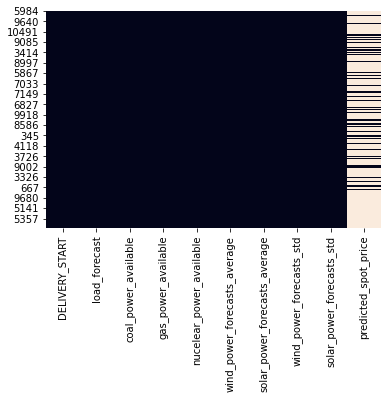

In [21]:
sns.heatmap(X_train.isna(),cbar=False) # vérification qu'il n'y a plus de valeur manquante dans load_forecast

In [22]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from scipy.stats import randint

delivery_starts = X_train['DELIVERY_START']

y_spot = X_train.dropna(subset=['predicted_spot_price'])['predicted_spot_price']
X_spot = X_train.dropna(subset=['predicted_spot_price'])
X_spot = X_spot.loc[:, X_spot.columns != 'predicted_spot_price']
X_spot = X_spot.set_index('DELIVERY_START')

print('nombre de valeurs non NaN: ', len(y_spot))

X_train_spot, X_test_spot, y_train_spot, y_test_spot = train_test_split(X_spot, y_spot, test_size=0.25)

clf = LinearRegression()
clf.fit(X_train_spot, y_train_spot)
print('linear regression score: ', clf.score(X_test_spot, y_test_spot))

clf = RandomForestRegressor()
clf.fit(X_train_spot, y_train_spot)
print('random forest regression score: ', clf.score(X_test_spot, y_test_spot))

clf = GradientBoostingRegressor()
clf.fit(X_train_spot, y_train_spot)
print('gradient boosting regression score: ', clf.score(X_test_spot, y_test_spot))

nombre de valeurs non NaN:  1267
linear regression score:  0.797742663327206
random forest regression score:  0.8525460057016047
gradient boosting regression score:  0.8591020477754523


In [23]:
X_predict_spot = X_train[X_train['predicted_spot_price'].isna()]
X_predict_spot = X_predict_spot.loc[:, X_predict_spot.columns != 'predicted_spot_price']
X_predict_spot = X_predict_spot.set_index('DELIVERY_START')

X_predict_rendu = X_rendu[X_rendu['predicted_spot_price'].isna()]
X_predict_rendu = X_predict_rendu.loc[:, X_predict_rendu.columns != 'predicted_spot_price']
X_predict_rendu = X_predict_rendu.set_index('DELIVERY_START')

X_predict_spot.insert(8, 'predicted_spot_price', clf.predict(X_predict_spot))
X_predict_rendu.insert(8, 'predicted_spot_price', clf.predict(X_predict_rendu))
X_predict_spot.head()

,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
DELIVERY_START,,,,,,,,,
2022-09-17 10:00:00+02:00,42593.0,2226.0,10819.0,27360.0,4079.0,6062.0,110.569548,36.878399,85.878258
2022-12-16 04:00:00+01:00,60213.0,3386.0,11742.0,41880.0,5734.0,0.0,132.079212,0.000000,144.096841
2022-05-24 19:00:00+02:00,47934.0,2806.0,11140.0,30099.0,2284.0,1473.0,161.078062,25.593526,108.104245
2022-09-28 14:00:00+02:00,50221.0,2226.0,10699.0,30240.0,3705.0,4787.0,45.202124,54.294675,101.094395
2022-10-23 11:00:00+02:00,40844.0,2806.0,11480.0,29250.0,7831.0,3098.0,288.872278,79.519559,82.430735


<AxesSubplot:>

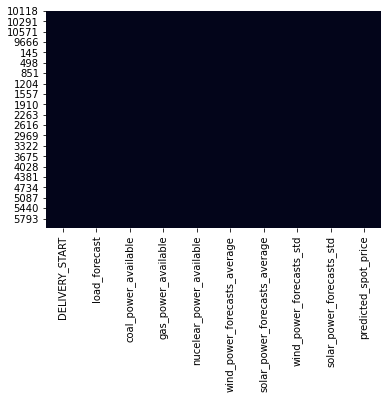

In [24]:
X_train = pd.concat([X_train[~X_train['predicted_spot_price'].isna()], X_predict_spot.reset_index('DELIVERY_START')])
X_rendu = pd.concat([X_rendu[~X_rendu['predicted_spot_price'].isna()], X_predict_rendu.reset_index('DELIVERY_START')])
sns.heatmap(X_train.isna(),cbar=False)

<AxesSubplot:>

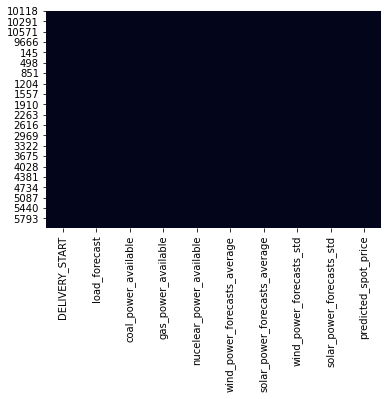

In [25]:
sns.heatmap(X_rendu.isna(),cbar=False)

In [26]:
X_train.to_csv('../data/X_train_clean.csv')
X_rendu.to_csv('../data/X_test_clean.csv')

On remarque bien que le database est maintenant dépourvu de valeurs NaN !

## Astuces et idées d'amélioration

- Réféchir à la modélation des différents facteurs qui font bouger les prix de l'électricité dans chaque pays pourra être utile. 

- Le jeu de données est relativement petit - c'est un "small data challenge" - alors attention à ne pas surapprendre les paramètres de vos modèles ! Il sera certainement utile de mettre en place de bonnes pratiques de validation croisée.


In [27]:
lm=LinearRegression()
Z = X_train_clean
lm.fit(Z, Y_train['spot_id_delta'])
Y_hat = lm.predict(X_train_clean)
sns.residplot(Z['load_forecast'], Y_train['spot_id_delta'])

NameError: name 'X_train_clean' is not defined

In [ ]:
Input = [('Scale',StandardScaler()),('polynomial',PolynomialFeatures(degree=2)),('model',LinearRegression())]
pipe=Pipeline(Input)
pipe.fit(X_train_clean,Y_train['spot_id_delta'])
Y_hat=pipe.predict(X_train_clean)

On voit quand on trace les résidus de la regression linéaire entre le load_forecast en France et la différence, une distribution équiprobable partout ce qui laisse penser que la regression linéaire est correcte


In [ ]:
RSQ_test= []
lr=LinearRegression()
X_test_clean = X_test.drop(['DELIVERY_START'], axis=1).fillna(0)
Y_test_clean = Y_train.drop(['DELIVERY_START'], axis=1).fillna(0)
order = [1,2,3,4,5]
for n in order :
    pr = PolynomialFeatures(degree=n)
    x_train_pr=pr.fit_transform(X_train_clean[['load_forecast']])
    x_test_pr=pr.fit_transform(X_test_clean[['load_forecast']])
    lr.fit(x_train_pr,Y_train_clean)
    RSQ_test.append(lr.score(x_test_pr,Y_test_clean))

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

RidgeModel = Ridge(alpha=0.1)
RidgeModel.fit(X_train_clean,Y_train_clean)
Yhat=RidgeModel.predict(X_train_clean)

parameters = [{'alpha': [0.001,2,10,100,1000,10000,100000,1000000000]}]
RR=Ridge()
Grid1=GridSearchCV(RR,parameters,cv=5)
Grid1.fit(X_train_clean,Y_train_clean)
Grid1.best_estimator_
scores=Grid1.cv_results_


for param, mean_val in zip(scores['params'],scores['mean_test_score']):
    print(param, "R^2 on test data:", mean_val)
    
